In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import mat73
import time

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_x_data = np.array(variables['Deriv'][0])
    deriv_x_data = deriv_x_data.squeeze()
    deriv_y_data = np.array(variables['Deriv'][1])
    deriv_y_data = deriv_y_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][2])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    th_coord=np.array(variables['g']['vs'][2])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_x_data=deriv_x_data,
                            deriv_y_data=deriv_y_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval

def get_deriv_x_function(matlab_var_dict):
   deriv_x_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_x_data'] ,  bounds_error=False, fill_value=None)
   return deriv_x_eval

def get_deriv_y_function(matlab_var_dict):
   deriv_y_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_y_data'] ,  bounds_error=False, fill_value=None)
   return deriv_y_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_opt_control( deriv_x_fun, deriv_y_fun, deriv_th_fun, state, vMax, vMin, angleMax, u_mode = 'max'):
    # if strcmp(uMode, 'max')
    # uOpt{2} = (deriv{3}>=0)*obj.angleMax + (deriv{3}<0)*(-obj.angleMax);  %steering control
    # det1 = deriv{1} .* cos(y{3}) + deriv{2} .* sin(y{3}) + deriv{3} .* tan(uOpt{2}).*(1/obj.L);
    # uOpt{1} = (det1 >= 0) * max(obj.vRange) + (det1 < 0) * min(obj.vRange);%vel control
    x_deriv = deriv_x_fun(state)
    y_deriv = deriv_y_fun(state)
    th_deriv = deriv_th_fun(state)
    if u_mode == 'max':        
        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
        det1 = x_deriv * np.cos(state[2]) + y_deriv * np.sin(state[2]) + th_deriv * np.tan(opt_angle)*(1/0.235) #0.235 is the wheelbase L
        opt_v = vMax * ( det1 >= 0 ) + vMin * ( det1 < 0 )
    else:
        raise NotImplementedError
    return opt_v, opt_angle

#---------------------- Load MATLAB ---------------------------------------------------------
#v1 baseline brt
matlab_var_dict= get_matlab_variables('/home/javier/jax_work/mppi/rc_car_mppi/brt_rc_wh_coarse_v1.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_function(matlab_var_dict)
lx_fun = get_lx_function(matlab_var_dict)
deriv_x_fun = get_deriv_x_function(matlab_var_dict)
deriv_y_fun = get_deriv_y_function(matlab_var_dict)
deriv_th_fun = get_deriv_th_function(matlab_var_dict)


In [11]:
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put

seed = 0
key = random.PRNGKey(seed)


#rc car dynamics
def rc3D_forward_propagate(state, control):
    #dx{1} = u{1} .* cos(x{3});
    #dx{2} = u{1} .* sin(x{3});
    #dx{3} = u{1} .* tan(u{2}) * (1/obj.L);

    # x = state[0]
    # y = state[1]
    th = state[2]

    x_dot = control[0] * jnp.cos(th) 
    y_dot = control[0] * jnp.sin(th)
    th_dot = control[0] * jnp.tan(control[1]) * (1/0.235) #0.235 is the wheelbase L

    state_dot = jnp.array([x_dot, y_dot, th_dot])
    return state_dot

def rc3D_dyn_batched(states, controls):
    return vmap(rc3D_dyn, in_axes=(0,0))(states, controls)

test_states = random.normal(key, (100,3))
test_controls = random.normal(key, (100,2))


print('vmap version:')
%timeit rc3D_dyn_batched(test_states,test_controls)
print('normal version:')
%timeit rc3D_dyn(test_states[0],test_controls[0])

vmap version:
6.48 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
normal version:
3.22 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Elapsed time for simulation: 0.1068 seconds
Shape of states array: (3, 50, 10)


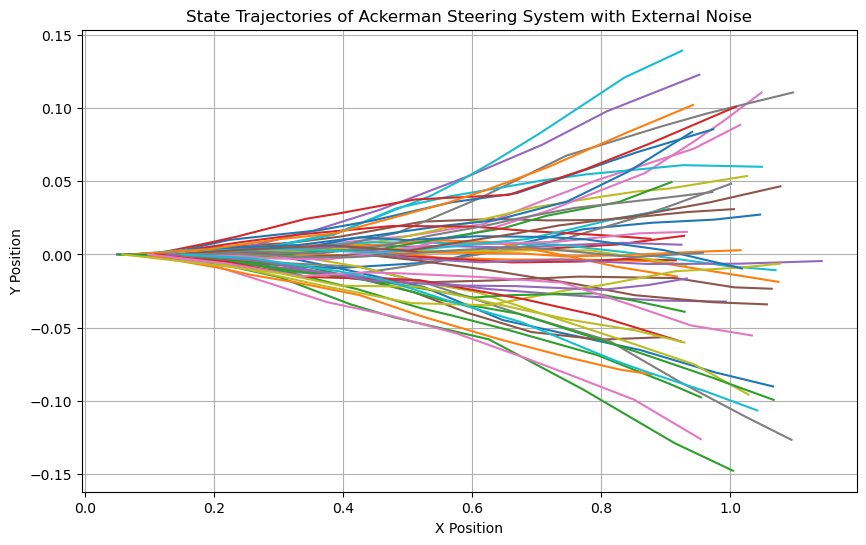

In [64]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import time

def ackerman_dynamics(state, control, dt=0.1, L=0.235):
    x, y, theta = state
    v, delta = control
    
    x_dot = v * jnp.cos(theta)
    y_dot = v * jnp.sin(theta)
    theta_dot = v * jnp.tan(delta) * (1 / L)
    
    new_x = x + x_dot * dt
    new_y = y + y_dot * dt
    new_theta = theta + theta_dot * dt
    
    return new_x, new_y, new_theta

def simulate_ackerman(initial_state, nominal_controls, control_noise, dt=0.1, L=0.235, v_min=0.5, v_max=1.5, delta_min=-0.2, delta_max=0.2):
    """
    Simulate the state evolution of a vehicle with Ackerman steering given an initial state, a sequence of nominal controls,
    and external noise. The disturbed controls are saturated within specified bounds.
    
    Parameters:
    - initial_state: A tuple (x, y, theta) representing the initial state.
    - nominal_controls: A sequence of nominal control inputs, each a tuple (v, delta).
    - control_noise: A sequence of noise to be added to the nominal controls.
    - dt: Time step for the simulation.
    - L: Wheelbase of the vehicle.
    - v_min, v_max: Minimum and maximum values for velocity.
    - delta_min, delta_max: Minimum and maximum values for steering angle.
    
    Returns:
    - states: An array of states representing the state evolution over time.
    """
    def step(state, control):                
        v = jnp.clip(control[0], v_min, v_max)
        delta = jnp.clip(control[1], delta_min, delta_max)        
        new_state = ackerman_dynamics(state, (v, delta), dt, L)
        return new_state, new_state  # Return new_state for both the next state and accumulation
    
    # Combine controls and noise
    disturbed_control = nominal_controls + control_noise
    
    # Use jax.lax.scan to iterate over the controls and accumulate the states
    _, states = jax.lax.scan(step, initial_state, disturbed_control)
    return states

# Example usage with jax.random
key = random.PRNGKey(0)
num_controls = 10
num_threads = 50

# Generate nominal control inputs
nominal_velocities = jnp.ones(num_controls)
nominal_steering_angles = jnp.zeros(num_controls)
nominal_controls = jnp.stack((nominal_velocities, nominal_steering_angles), axis=1)

# Generate random noise for multiple trajectories
control_noise = random.normal(key, shape=(num_threads, num_controls, 2)) * jnp.array([0.3, 0.1])  # Adjust the scale of noise as needed

initial_state = (0.0, 0.0, 0.0)

# Vectorize the simulation function to run multiple trajectories in parallel
simulate_ackerman_parallel = jax.vmap(simulate_ackerman, in_axes=(None, None, 0))

# Perform the simulation
start_time = time.time()
states_parallel = simulate_ackerman_parallel(initial_state, nominal_controls, control_noise)
end_time = time.time()

# Print the elapsed time
print(f"Elapsed time for simulation: {end_time - start_time:.4f} seconds")

# Print shapes of the states
print("Shape of states array:", jnp.array(states_parallel).shape)

# Visualize the state trajectories
plt.figure(figsize=(10, 6))
for i in range(num_threads):
    x_coords = jnp.array(states_parallel)[0, i, :]
    y_coords = jnp.array(states_parallel)[1, i, :]
    plt.plot(x_coords, y_coords, label=f'Trajectory {i+1}')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Trajectories of Ackerman Steering System with External Noise')
plt.grid(True)
plt.show()

In [ ]:

#

value at initial state:  [0.27450657]
threads used: 39
threads used: 39
threads used: 39
threads used: 40
threads used: 39
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 39
threads used: 37
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 37
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads us

interactive(children=(IntSlider(value=199, description='idx_to_plot', max=398), Output()), _dom_classes=('widg…

<function __main__.plot_func(idx_to_plot)>